In [ ]:
# update the pip installation
%pip install --upgrade pip
%pip install --upgrade setuptools
# dependencies for influxdb and plotting graphs
%pip install numpy influxdb-client influxdb-client[extra] matplotlib pandas ipywidgets plotly
# dependencies for fbprophet
%pip install convertdate lunarcalendar holidays==0.24 tqdm pystan==2.19.1.1

In [ ]:
%pip install fbprophet --no-cache-dir

In [1]:
# import required libraries
import os
from datetime import datetime
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS
import pandas as pd

client = InfluxDBClient.from_config_file('config.ini')
organization = 'fhswf'
bucket = 'household_energy_data'

In [ ]:
write_api = client.write_api(write_options=SYNCHRONOUS)
dataframe = pd.read_csv('D202.csv')

# write the energy usage data from the dataframe into the InfluxDB bucket
for index, row in dataframe.iterrows():
    print(index, end=' ')
    # create a valid timestamp for InfluxDB to parse
    stamp = datetime.strptime(f"{row['DATE']}, {row['START TIME']}",
                                "%m/%d/%Y, %H:%M")
    # prepare the data points to ingest
    p = Point(row["TYPE"])\
        .time(stamp, WritePrecision.NS)\
        .field("usage(KWh)", row["USAGE"])\
        .tag("cost", row["COST"])

    write_api.write(bucket=bucket, org=organization, record=p)

In [ ]:
# read data from the bucket to work on it
query_api = client.query_api()

query = f'from(bucket:"{bucket}")' \
        ' |> range(start:2016-10-22T00:00:00Z, stop:2018-10-24T23:45:00Z)'\
        ' |> filter(fn: (r) => r._measurement == "Electric usage")' \
        ' |> filter(fn: (r) => r._field == "usage(KWh)")'

result = query_api.query(org=organization, query=query)

data = {'y': [], 'ds': []}

for table in result:

    for record in table.records:

        data['y'].append(record.get_value())

        data['ds'].append(record.get_time())

df = pd.DataFrame(data=data)

df.to_csv('Processed_D202.csv', index=False)

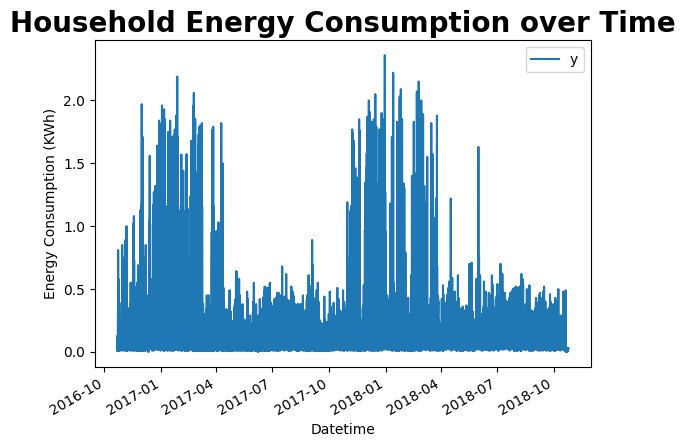

In [2]:
import fbprophet
import matplotlib.pyplot as plt

df = pd.read_csv('Processed_D202.csv')
# convert the datetime to something matplotlib can handle
df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
df_copy = df.set_index('ds')
# plot the energy consumption over the whole dataset
df_copy.plot(kind='line', 
                        xlabel='Datetime', 
                        ylabel='Energy Consumption (KWh)', 
                        )

plt.title('Household Energy Consumption over Time', fontweight='bold', fontsize=20)
plt.show()

Initial log joint probability = -348.949
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93        138463   8.83028e-06       5980.04   1.089e-09       0.001      166  LS failed, Hessian reset 
      99        138463   2.56792e-06       6114.05        3.46       0.346      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116        138463   5.40843e-08       5599.35      0.1362      0.5763      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


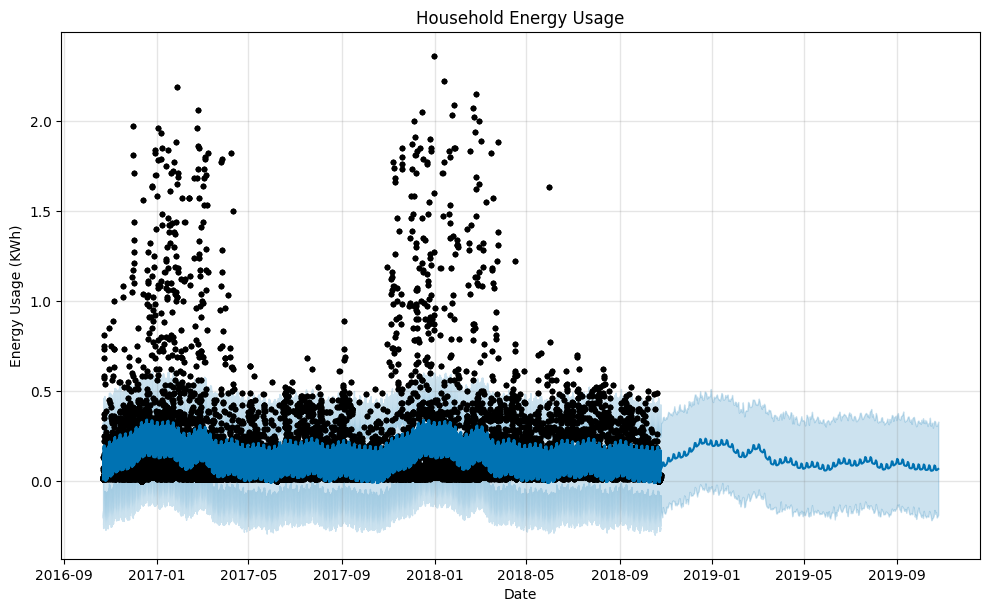

In [3]:
energy_prophet = fbprophet.Prophet(changepoint_prior_scale=0.0005)
# load the dataframes into the prophet object
energy_prophet.fit(df)
energy_forecast = energy_prophet.make_future_dataframe(periods=365, freq='D')
energy_forecast = energy_prophet.predict(energy_forecast)
# plot the prediction for the next 365 days
energy_prophet.plot(energy_forecast, xlabel = 'Date', ylabel = 'Energy Usage (KWh)') # 0.0005
plt.title('Household Energy Usage')
plt.show()

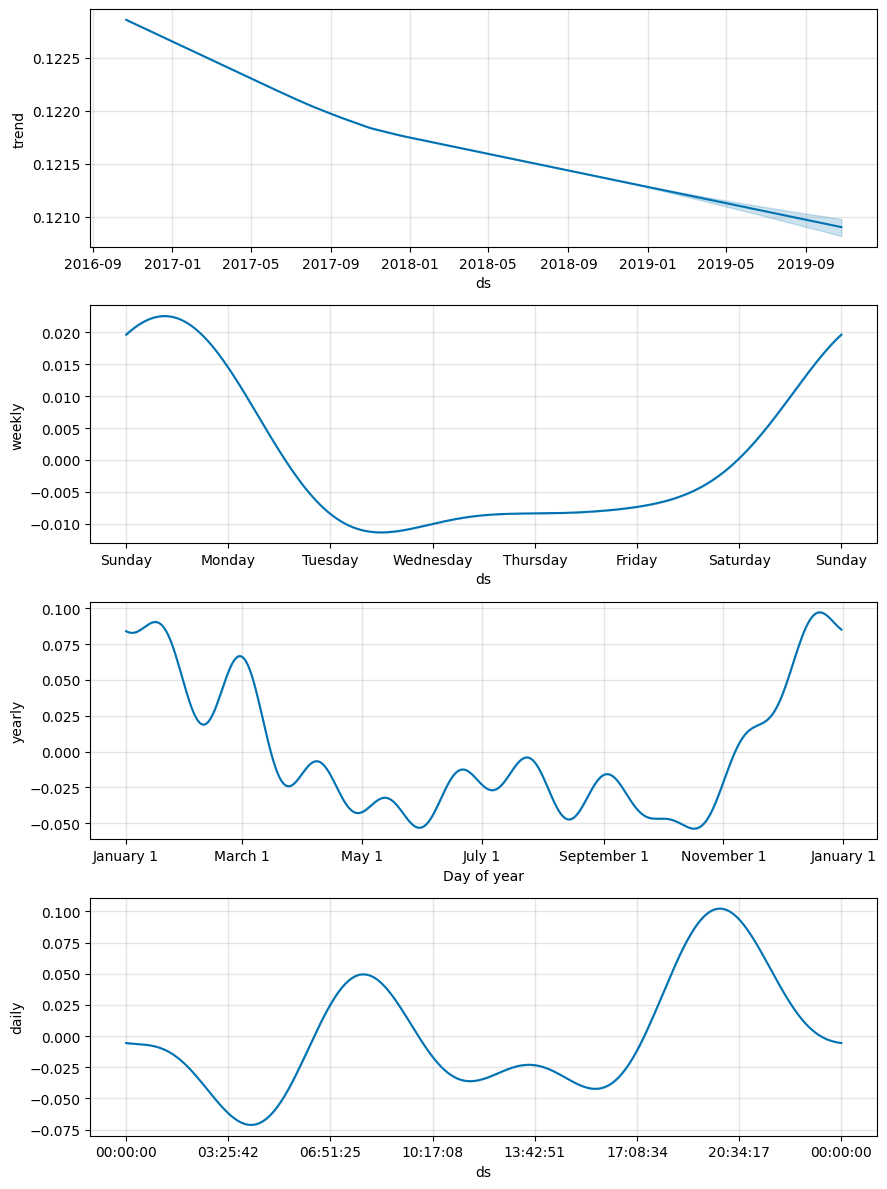

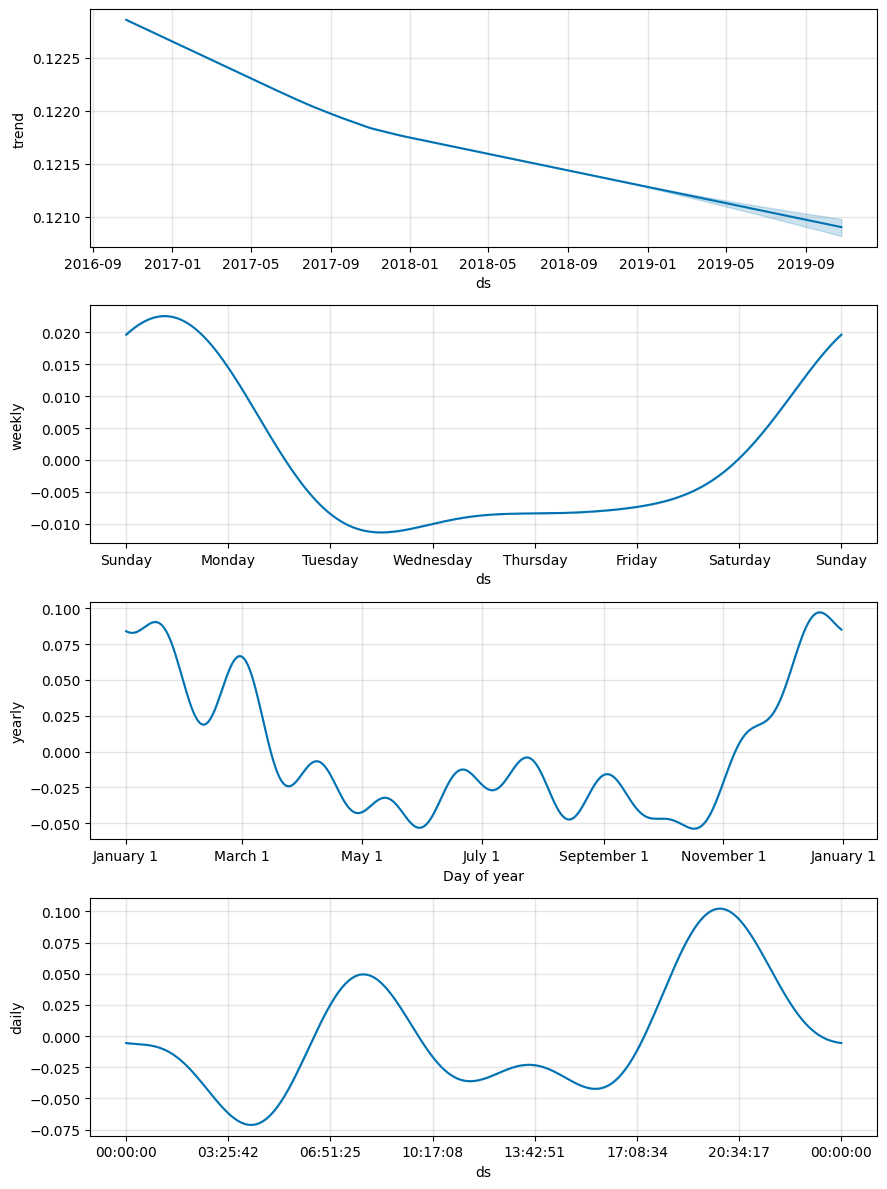

In [5]:
energy_prophet.plot_components(energy_forecast)